# Browse
1. Introduce problem: optimizing my workflow by understanding my current habits
    + Questions:
        1. When do I spend the most time browsing the internet?
        2. How much of my browsing is programming related?
        3. How much time do I spend writing code?
        4. Through the amalgomation of the two above: how much time am I spending writing/debugging code?
2. What can I look at?
    + Commit History
    + Browser History
    + Wakatime
3. Get and clean:
    + browser history
        * Oberservations
    + Get wakatime
        * Obersvations
4. Redfine questions in the context of the datasets
5. Answer them with visualizations
    + Different colors for productive v.s unproductive work

In [339]:
import pandas as pd

# read in chrome_hist
hist_df = pd.read_csv("datasets/chrome_hist.csv")

hist_df.head()

,id,url,title,visit_count,typed_count,last_visit_time,hidden
0,348,https://www.facebook.com/profile.php?id=100004...,Rohan Mishra,264,126,13162785960093394,0
1,551,https://www.messenger.com/t/1002100799843065,Messenger,112,0,13162868680446667,0
2,704,https://github.com/Meeshbhoombah,Meeshbhoombah (Rohan Mishra),197,52,13162871708126532,0
3,1110,https://www.makeschool.com/users/auth/facebook,Log into Facebook | Facebook,4,0,13157852987745316,0
4,1347,https://www.messenger.com/t/dhruv.mand,(1) Messenger,7,0,13160376562930578,0


## Obeservations
Looking at the dataset, each row appears to be a unique url. It looks like a URL can only appear once in the database, which is why, so that the total number of visits to a website can be determined while still avoiding duplication. The attribute `last_visit_time` is named as such for that same reason, as all visits cannot be represented without breaking `SQL` convention.

This data will yield variable results if parsed through incorrectly because of the value of certain attributes, like the `title` attribute, do not follow a set pattern. This is **bad news bears**. Thankfully, the website can be guessed from the `url_name` by splitting the string after `https://www.`, which is a prefix that they each shares. The end of a websites's name is delimited by `.com`.

## Time Heatmap
I want to gain an insight into how often I am browsing the internet on my Mac so I decided to create a time heatmap of my browsing data so I can easily interpret that. I want to see an hourly breakdown of my browsing activity on a daily basis, so I need to convert the `last_visit_time` attribute to a readable date format. Initally, I just tried to convert my timestamp
**Chrome's timestamp is formatted as microseconds from January 1, 1601**.

- Inital unable to read error 
- Googling to find format
- Aftewards integer size error
- Fixed with math

Give an example of why it works, both dates are in the past, adding two negatives is a smaller negative, creates a simple way to go back in time and determine the time at which something happens.


In [340]:
import datetime
import numpy as np

def to_datestring(timestamp):
    """ Converts a Chrome timestamp to a readable date"""
    # convert numpy.int64 to int
    timpstamp = np.asscalar(timestamp)
    
    # convert start date to mircoseconds 
    # relative to Unix time, Google Chrome 
    # uses January 1, 1601
    epoch_start = datetime.datetime(1601, 1, 1)
    
    # convert visit time relative to Unix time
    delta = datetime.timedelta(microseconds = int(timestamp))
    
    # add to find visit time
    visit_time = epoch_start + delta
    
    # isoformat
    return visit_time.isoformat()


def test_to_datestring():
    last_visit_times = hist_df["last_visit_time"].values

    # splice list to test
    last_visit_times = last_visit_times[:5]

    # convert times
    for visit_time in last_visit_times: 
        print(to_datestring(visit_time))
        
test_to_datestring()

2018-02-11T01:26:00.093394
2018-02-12T00:24:40.446667
2018-02-12T01:15:08.126532
2017-12-15T23:09:47.745316
2018-01-14T04:09:22.930578


### Create Heatmap Data
Note that I figured that out, let's 

In [341]:
week = {
    0 : "Sunday",
    1 : "Monday",
    2 : "Tuesday",
    3 : "Wednesday",
    4 : "Thursday",
    5 : "Friday",
    6 : "Saturday"
}

# get all timestamps
last_visit_timestamps = hist_df["last_visit_time"].values

# create empty list for heatmap data
heatmap_data = []

# convert each timestamps
for timestamp in last_visit_timestamps:
    
    # convert to datestring
    datestring = to_datestring(timestamp)
    
    # split into date and time
    date, time = datestring.split("T")
    
    # split date and convert to integer values
    year, month, day = [int(x) for x in date.split("-")]
    
    # convert to an integer value of the day of the week
    day_int = datetime.datetime(year, month, day).weekday()
    
    # lookup day of the week
    day = week[day_int]
    
    # only need hour of day
    hour = int(time[:2])
    
    # TODO - Fixing the text BREAKS TIME
    """
    # format hour
    if hour == 0:
        hour = "12AM"
    elif hour <= 12:
        hour = str(hour) + "AM"
    else:
        hour = str(hour // 2) + "PM"
    """
    
    # add to data
    heatmap_data.append((day, hour, 1))
    
day_hour_df = pd.DataFrame(heatmap_data)

# add column names
day_hour_df.columns = ["day", "hour", "page loads"]

# order the days of the week
day_hour_df["day"] = day_hour_df["day"].astype('category', categories=["Sunday", "Monday", "Tuesday", "Wednesday", 
                                                                       "Thursday", "Friday", "Saturday"])

day_hour_df.head(5)

,day,hour,page loads
0,Saturday,1,1
1,Sunday,0,1
2,Sunday,1,1
3,Thursday,23,1
4,Saturday,4,1


# Convert to Pivot Table to Use for Heatmap

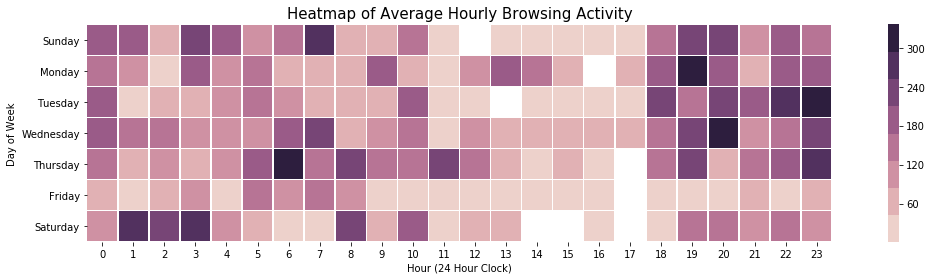

In [345]:
# count page loads and organize by hour/day
heatmap = day_hour_df.groupby(["day", "hour"]).count()

# convert to pivot table
heatmap_pivot_table = heatmap.pivot_table("page loads", "day", "hour")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_heatmap(pivot_table):
    plt.figure(figsize=(20,4))
    plt.title('Heatmap of Average Hourly Browsing Activity', size = 15)

    # create heatmaps
    avg_browsing_activity = sns.heatmap(heatmap_pivot_table, annot = False, fmt = ".1f", 
                                        linewidths = .5, square = True, 
                                        cmap = sns.cubehelix_palette(8))

    # make pretty
    avg_browsing_activity.set(xlabel = "Hour (24 Hour Clock)", ylabel="Day of Week")
    
plot_heatmap(heatmap_pivot_table)